#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/KT/6차/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [7]:
sales['Date'].min(), sales['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-02-28 00:00:00'))

In [8]:
def make_dataset(Product_ID):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()

    return temp3


### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [9]:
data03 = make_dataset(3)
data03.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,9853.0,4422,15153.0,Thursday,1,10142.0,45969,95.140000
1,2014-01-03,8647.0,4167,15606.0,Friday,1,8980.0,42386,94.400000
2,2014-01-04,15153.0,5341,7900.0,Saturday,1,15684.0,52293,94.400000
3,2014-01-05,15606.0,5123,7188.0,Sunday,1,15606.0,49199,94.400000
4,2014-01-06,7900.0,3917,8800.0,Monday,1,8083.0,39105,93.973333


In [10]:
data12 = make_dataset(12)
data12.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,9647.0,4422,14188.0,Thursday,1,15195.550,45969,95.140000
1,2014-01-03,8879.0,4167,14490.0,Friday,1,13952.689,42386,94.400000
2,2014-01-04,14188.0,5341,7614.0,Saturday,1,22059.125,52293,94.400000
3,2014-01-05,14490.0,5123,7124.0,Sunday,1,22443.851,49199,94.400000
4,2014-01-06,7614.0,3917,8683.0,Monday,1,11853.281,39105,93.973333


In [11]:
data42 = make_dataset(42)
data42.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,76.0,4422,78.0,Thursday,1,1962.62200,45969,95.140000
1,2014-01-03,74.0,4167,88.0,Friday,1,2144.99700,42386,94.400000
2,2014-01-04,78.0,5341,65.0,Saturday,1,2773.83000,52293,94.400000
3,2014-01-05,88.0,5123,78.0,Sunday,1,2542.78700,49199,94.400000
4,2014-01-06,65.0,3917,73.0,Monday,1,1284.36197,39105,93.973333


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [12]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [76]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date','WTI_Price', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 14
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(32, input_shape = (ts, nfeat)),
                        Dense(16),
                        Dense(8),
                        Dense(1)])
model03_01.summary()


* **모델링**

In [ ]:
model03_01.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 1).history
dl_history_plot(hist)

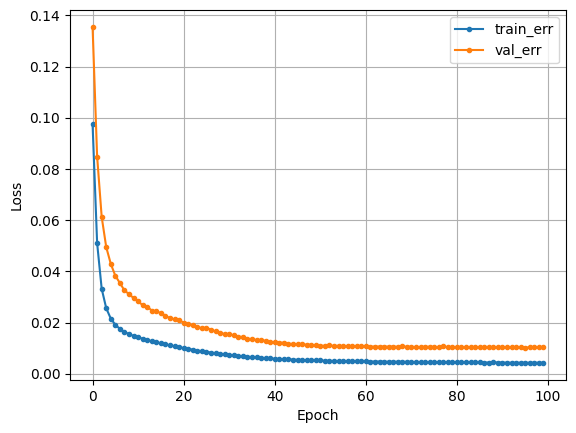

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE : ', root_mean_squared_error(y_val2, pred) )
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

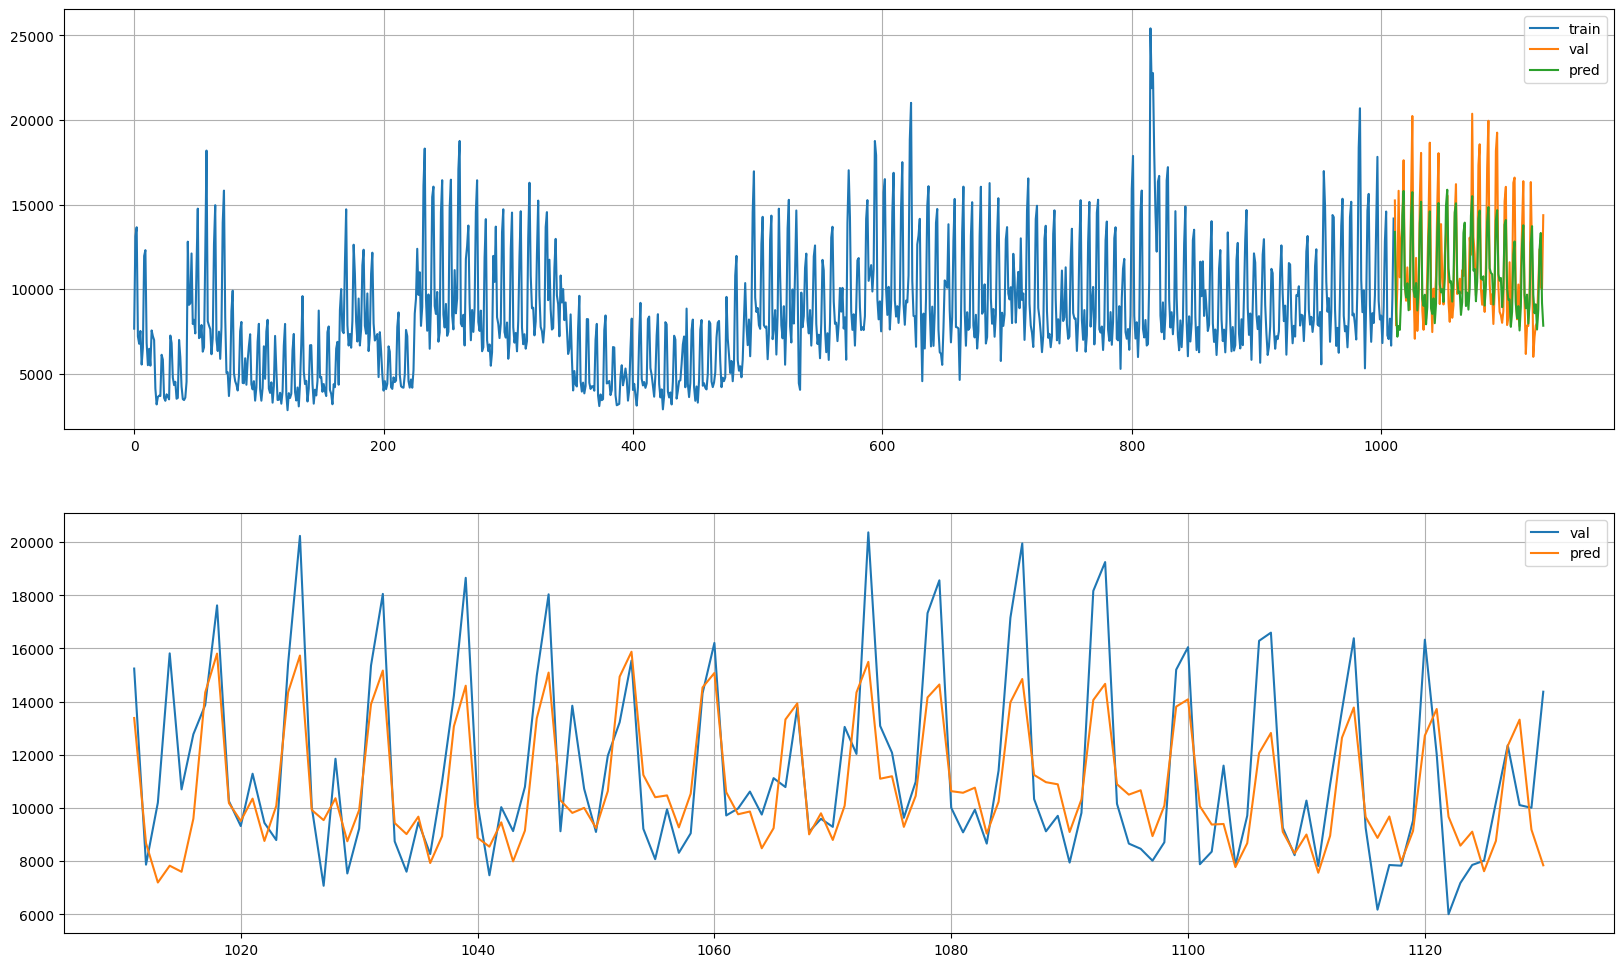

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [201]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1018, 7, 23), (120, 7, 23))

In [202]:
clear_session()

_, ts, nfeat = x_train.shape

* **모델링**

In [203]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, BatchNormalization, LayerNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras import backend as K

In [204]:
model03_01 = Sequential([
    LSTM(16, return_sequences=True, input_shape=(ts, nfeat)),
    LayerNormalization(),
    LSTM(8),
    LayerNormalization(),
    Dense(4, activation='relu'),
    Dense(1)
])

In [205]:
# 모델 컴파일
model03_01.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model03_01.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]

)

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2994 - val_loss: 0.0209
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - val_loss: 0.0253
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - val_loss: 0.0195
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0134 - val_loss: 0.0184
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0116 - val_loss: 0.0165
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108 - val_loss: 0.0140
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098 - val_loss: 0.0133
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - val_loss: 0.0136
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - val_loss: 0.0141
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 0.0131
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

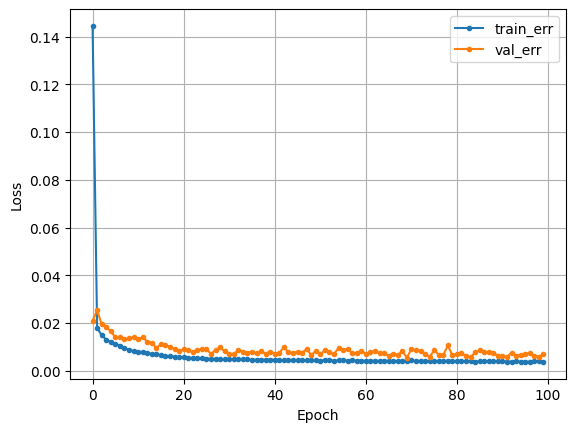

In [206]:
dl_history_plot(history.history)

In [207]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
MAE :  1900.5074178059897
MAPE :  0.1481827973386163
R2 :  0.542220234235318


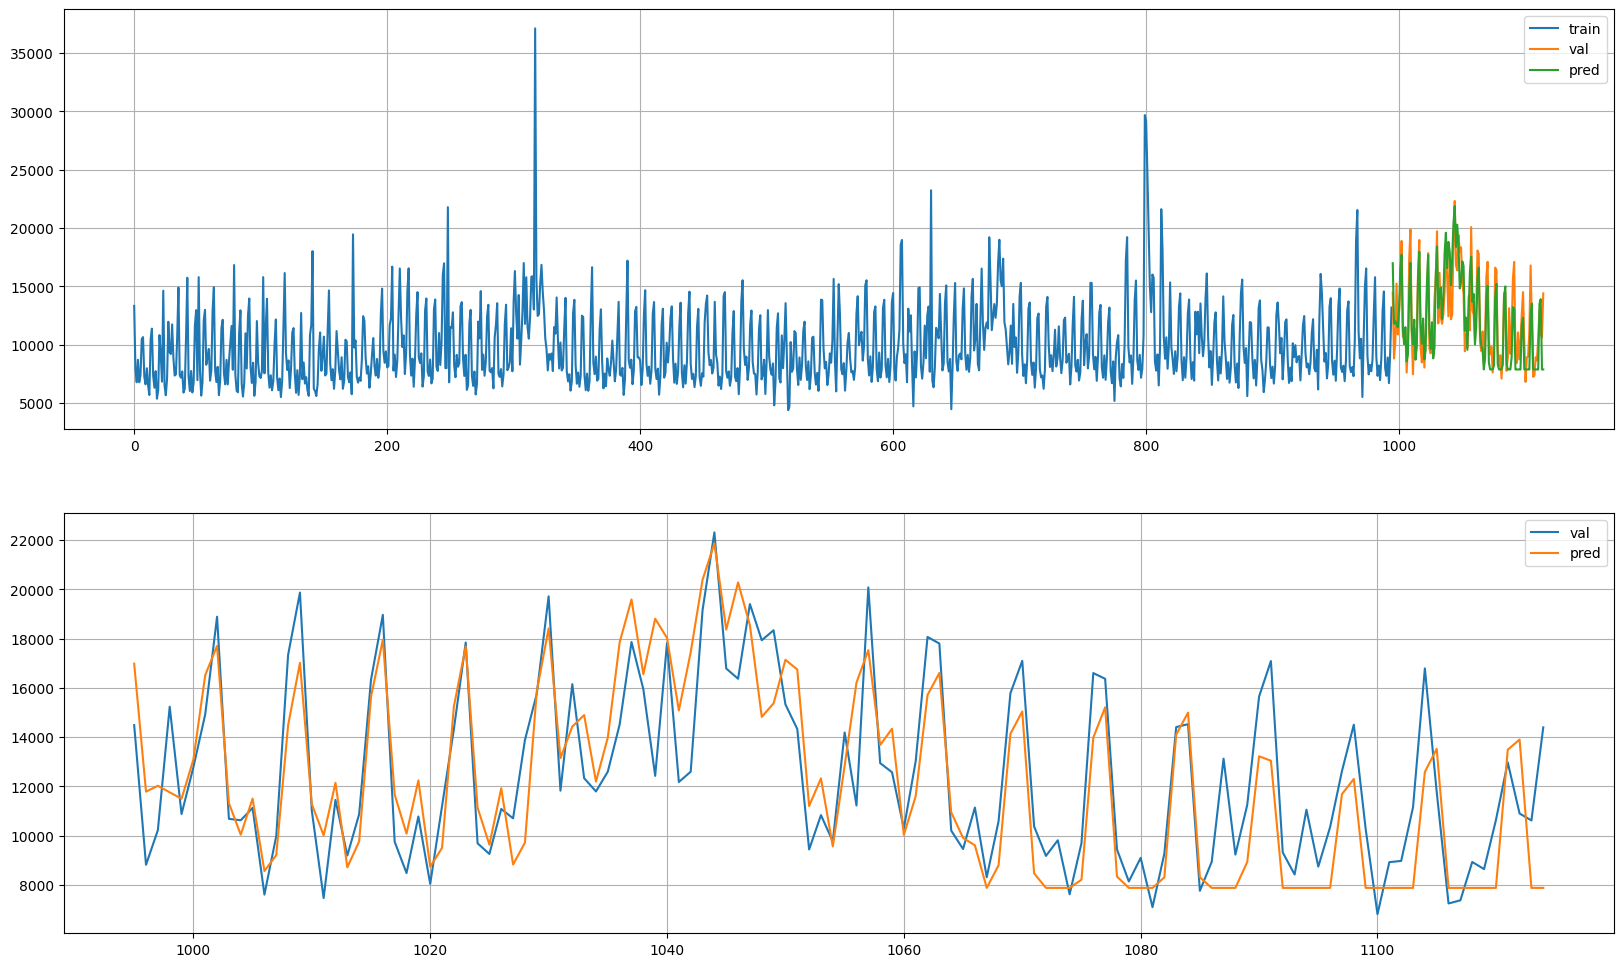

In [190]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [197]:
model42_01 = Sequential([
    LSTM(16, return_sequences=True, input_shape=(ts, nfeat)),
    LayerNormalization(),
    LSTM(8),
    LayerNormalization(),
    Dense(4, activation='relu'),
    Dense(1)
])

In [198]:
# 모델 컴파일
model42_01.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_42.keras', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model42_01.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]

)

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1921 - val_loss: 0.0452
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0461 - val_loss: 0.0151
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0162 - val_loss: 0.0115
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0099 - val_loss: 0.0121
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0097 - val_loss: 0.0116
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - val_loss: 0.0105
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step -

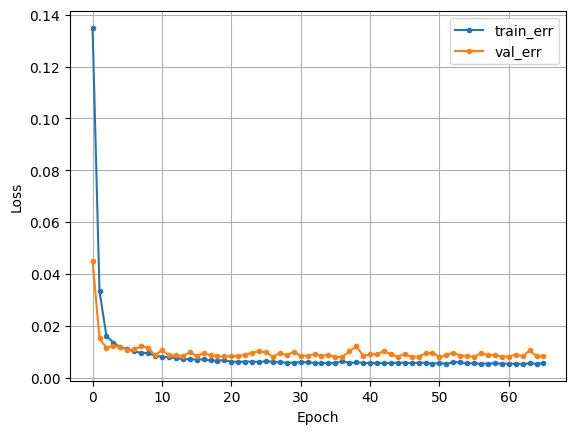

In [199]:
dl_history_plot(history.history)

In [200]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
MAE :  10.550504557291667
MAPE :  0.11105659854860205
R2 :  0.6647534324272464


## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 14
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_09 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model03_09.summary()

* **모델링**

In [ ]:
model03_09.compile(optimizer='adam', loss = 'mse')
hist = model03_09.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

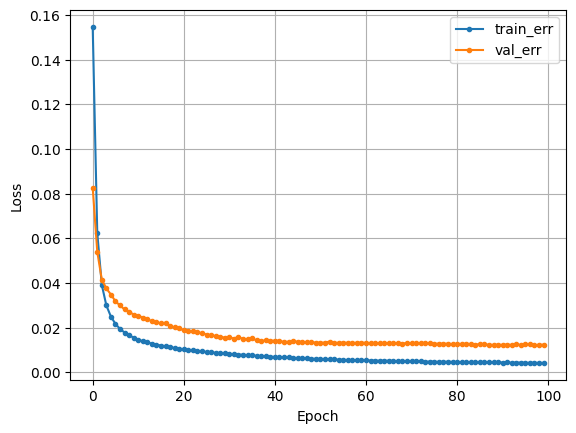

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_09.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE : ', root_mean_squared_error(y_val2, pred) )
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

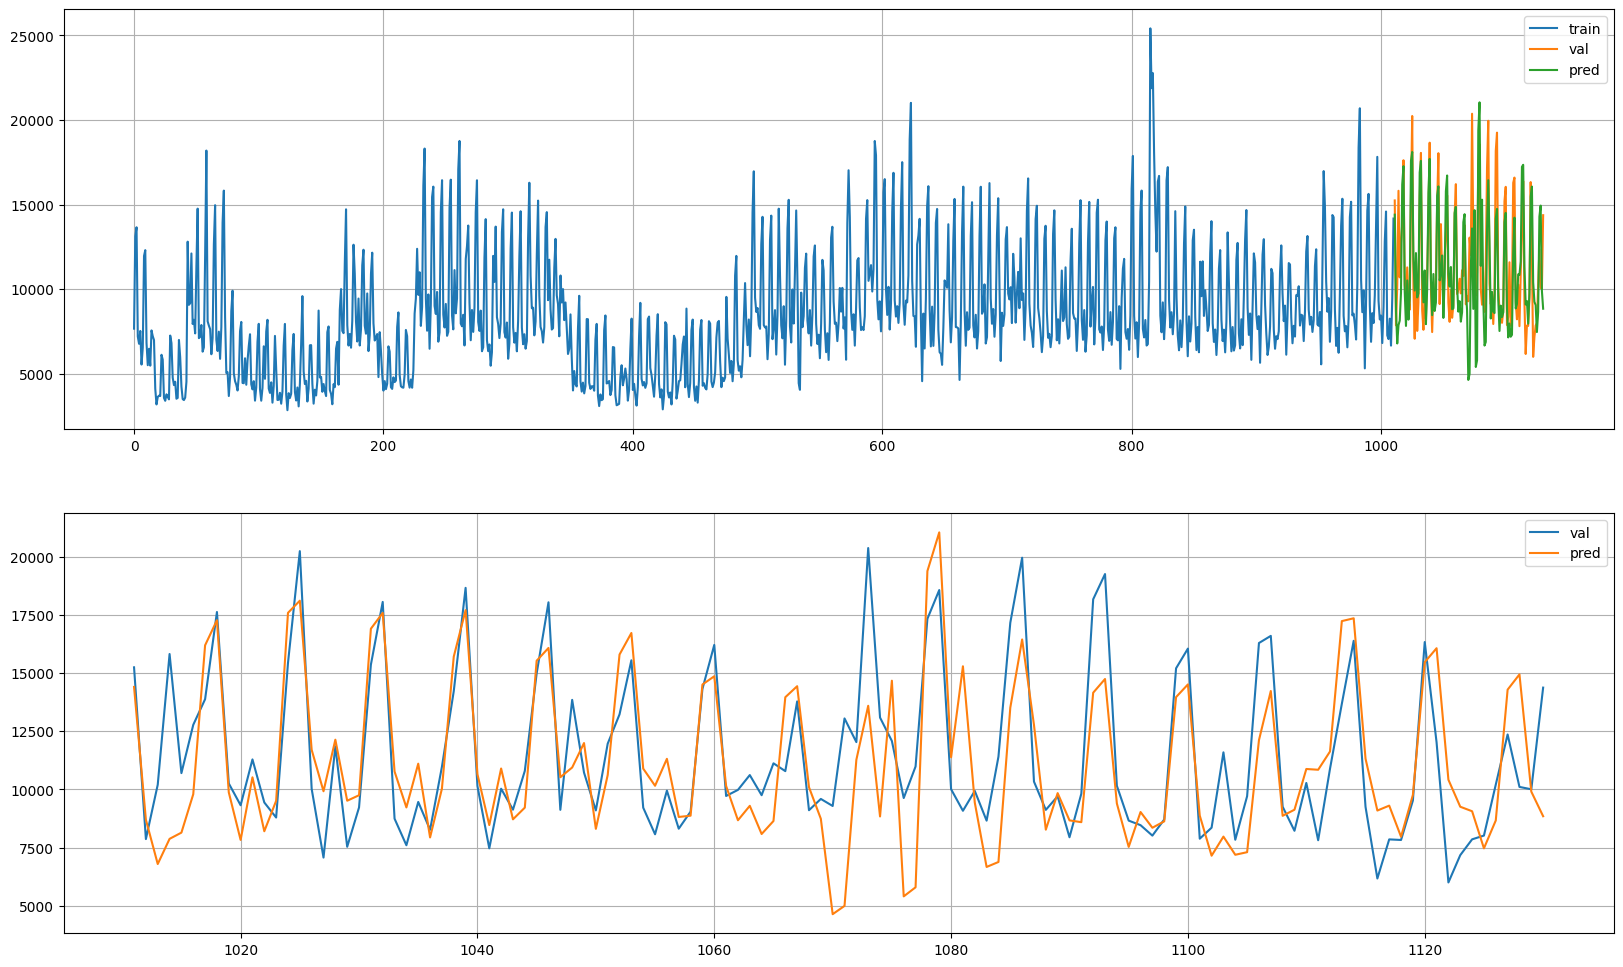

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [178]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras import backend as K

* **모델링**

In [179]:
# 이전 세션 초기화
K.clear_session()

# Conv1D 모델 정의
model_conv1d = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ts, nfeat)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# 모델 요약 출력
model_conv1d.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 4, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,729 (788.00 KB)

 Trainable params: 201,729 (788.00 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
# 모델 컴파일
model_conv1d.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_conv1d_model.keras', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model_conv1d.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.0406 - val_loss: 0.0234
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0144
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0110
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0131
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

In [181]:
# 스케일링 된 데이터 돌려서 평가하기
conv_pred = model_conv1d.predict(x_val)
conv_pred = conv_pred * (y_max - y_min) + y_min
y_val3 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val3, conv_pred))
print('MAPE : ',mean_absolute_percentage_error(y_val3, conv_pred))
print('R2 : ',r2_score(y_val3, conv_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
MAE :  2278.4236450195312
MAPE :  0.1700553560205636
R2 :  0.3440846011672346


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [231]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
def preprocessing4predict([sales_test, ....], product_ID = 3, scaler = scaler, ....):



    return x_test, y_test

In [278]:
def preprocessing4predict(data_list, product_ID=3, scaler=None, timesteps=7, y_scale=True, y_min=None, y_max=None):
    sales_test, orders_test, oil_price_test, products, stores = data_list

    # 1. 리드 타임과 매출 데이터 필터링
    leadTime = products.loc[products['Product_ID'] == product_ID, 'LeadTime'].values[0]
    temp1 = sales_test.loc[(sales_test['Store_ID'] == 44) & (sales_test['Product_ID'] == product_ID), ['Date', 'Qty']]
    temp2 = orders_test.loc[orders_test['Store_ID'] == 44, ['Date', 'CustomerCount']]
    temp3 = pd.merge(temp1, temp2, on="Date", how="left")
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace=True)

    # 2. Feature Engineering
    # 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'] == product_ID, 'Category'].values[0]
    Product_IDs = products.loc[products['Category'] == Category, 'Product_ID'].tolist()
    temp4 = sales_test.loc[(sales_test['Store_ID'] == 44) & (sales_test['Product_ID'].isin(Product_IDs))].groupby('Date', as_index=False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, on="Date", how="left")

    # 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID'] == 44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City'] == City, 'Store_ID'].tolist()
    temp5 = orders_test.loc[orders_test['Store_ID'].isin(Store_IDs)].groupby('Date', as_index=False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, on="Date", how="left")

    # oil price MA14 적용
    temp3 = pd.merge(temp3, oil_price_test, on="Date", how="left")
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()

    # 3. 타겟 및 불필요한 열 제거
    target = 'target'
    x = temp3.drop(['Date', 'WTI_Price', target], axis=1)
    y = temp3.loc[:, target]

    # 4. 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    x = pd.get_dummies(x, columns=['WeekDay', 'Month'])
    col_names = list(x.columns)

    # 5. 스케일링 (훈련 시 사용한 scaler와 y_min, y_max 사용)
    if scaler is not None:
        x = scaler.transform(x)
    else:
        raise ValueError("Scaler must be provided for consistent scaling.")

    x = pd.DataFrame(x, columns=col_names)

    # y 스케일링 복원
    if y_scale and y_min is not None and y_max is not None:
        y = (y - y_min) / (y_max - y_min)

    # 6. 3차원 변환
    x_test, y_test = temporalize(x, y, timesteps)

    return x_test, y_test

In [292]:
# 테스트 데이터 전처리
x_test, y_test = preprocessing4predict(
    [sales_test, orders_test, oil_price_test, products, stores],
    product_ID=12,
    scaler=scaler,
    timesteps=7,
    y_scale=True,
    y_min=y_min,
    y_max=y_max
)

# 모델 로드 및 예측
from keras.models import load_model
model = load_model('/content/best_model.keras')
y_pred = model.predict(x_test)

# 스케일링 복원 (y가 스케일링된 경우)
y_pred = y_pred * (y_max - y_min) + y_min


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


In [293]:
y_test_original = y_test * (y_max - y_min) + y_min

In [294]:
y_pred

array([[ 6339.7593],
       [ 8354.227 ],
       [13146.789 ],
       [14759.145 ],
       [ 8000.841 ],
       [ 6906.9634],
       [ 7719.249 ],
       [ 6433.8945],
       [ 8343.076 ],
       [13102.05  ],
       [14832.396 ],
       [ 7930.9385],
       [ 6510.2754],
       [ 7575.799 ],
       [ 6473.6997],
       [ 8520.104 ],
       [13303.077 ],
       [14846.441 ],
       [ 7996.7803],
       [ 6813.9316],
       [ 7684.869 ],
       [ 6432.512 ],
       [ 8368.591 ]], dtype=float32)

In [295]:
y_test_original

array([ 8208.,  9083., 14392., 16478.,  8715.,  7505., 10453.,  8592.,
       11463., 16763., 16948.,  9052.,  8945.,  9165.,  8075.,  9876.,
       15023., 15789.,  8926.,  5459., 10035.,  8094., 12173.])

In [281]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# 성능 평가
mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("R2:", r2)

MAE: 1805.498046875
MAPE: 0.17269240068030758
R2: 0.6309373913748861


In [236]:
# 테스트 데이터 전처리
x_test, y_test = preprocessing4predict(
    [sales_test, orders_test, oil_price_test, products, stores],
    product_ID=42,
    scaler=scaler,
    timesteps=7,
    y_scale=True,
    y_min=y_min,
    y_max=y_max
)

# 모델 로드 및 예측
from keras.models import load_model
model = load_model('/content/model_42.keras')
y_pred = model.predict(x_test)

# 스케일링 복원 (y가 스케일링된 경우)
y_pred = y_pred * (y_max - y_min) + y_min
y_test_original = y_test * (y_max - y_min) + y_min

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


In [237]:
# 성능 평가
mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("R2:", r2)

MAE: 15864.760529891304
MAPE: 145.2348842471798
R2: -1023676.3828631816


* 예측해보기

In [261]:
# 테스트 데이터 전처리
x_test, y_test = preprocessing4predict(
    [sales_test, orders_test, oil_price_test, products, stores],
    product_ID=3,
    scaler=scaler,
    timesteps=14,
    y_scale=True,
    y_min=y_min,
    y_max=y_max
)

# 모델 로드 및 예측
from keras.models import load_model
model = load_model('/content/model03_01_lstm.keras')
y_pred = model.predict(x_test)

# 스케일링 복원 (y가 스케일링된 경우)
y_pred = y_pred * (y_max - y_min) + y_min
y_test_original = y_test * (y_max - y_min) + y_min

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [262]:
# 성능 평가
mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("R2:", r2)

MAE: 9363.754516601562
MAPE: 0.8023450550595249
R2: -4.2771729314596385


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [282]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [300]:
# 필요한 변수 설정
y = y_test_original  # 실제 판매량
pred = y_pred  # 모델의 예측된 판매량
safe_stock =  6500 # 예: 안전 재고량을 10으로 설정
price = 6  # 예: 제품 단가를 100으로 설정

# 함수 실행
inventory = inv_simulator(y, pred, safe_stock, price)


일평균 재고량     : 10619.738
일평균 재고 금액  : 63718.428
일평균 재고회전율 : 1.093
기회손실 수량     : 0.0


In [244]:
# 필요한 변수 설정
y = y_test_original  # 실제 판매량
pred = y_pred  # 모델의 예측된 판매량
safe_stock = 0  # 예: 안전 재고량을 10으로 설정
price = 5  # 예: 제품 단가를 100으로 설정

# 함수 실행
inventory = inv_simulator(y, pred, safe_stock, price)

일평균 재고량     : 26956.19
일평균 재고 금액  : 134780.94999999998
일평균 재고회전율 : 0.194
기회손실 수량     : 0.0


In [277]:
# 필요한 변수 설정
y = y_test_original  # 실제 판매량
pred = y_pred  # 모델의 예측된 판매량
safe_stock = 10000  # 예: 안전 재고량을 10으로 설정
price = 8  # 예: 제품 단가를 100으로 설정

# 함수 실행
inventory = inv_simulator(y, pred, safe_stock, price)

일평균 재고량     : 8343.929
일평균 재고 금액  : 66751.432
일평균 재고회전율 : 1.347
기회손실 수량     : -34406.0
